### 1. Zaimplementuj algorytm gęstego kodowania w jednym z wybranych symulatorów

In [7]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install qiskit[visualization]

In [63]:
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Batch, SamplerV2
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Tworzymy obwód
qc_dense = QuantumCircuit(4, 2)

# 1. Tworzymy splątanie dwóch qubitów w bazie Bella
qc_dense.h(2)    # Bramkę Hadamarda na qubicie 2 (część splątania)
qc_dense.cx(2, 3)  # Bramkę CNOT na qubitach 2 i 3 (część splątania)

# 2. Działania Alicji na pierwszym z jej qubitów:
qc_dense.x(1) # Zmienia qubit 1 w stan |1>
qc_dense.x(0) # Zmienia qubit 0 w stan |1>

qc_dense.cx(1, 2)  # Bramkę X na qubicie 2, kontrolowaną przez qubit 1 Alicji
qc_dense.cz(0, 2)  # Bramkę Z na qubicie 2, kontrolowaną przez qubit 0 Alicji

# 3. Przywrócenie do bazy obliczeniowej
qc_dense.cx(2, 3)  # Odwracamy CNOT
qc_dense.h(2)  # Odwracamy Bramkę Hadamarda

# 4. Pomiar na qubitach 2 i 3 (to są qubity, które są dla nas istotne)
qc_dense.measure([2, 3], [0, 1])

# Rysujemy obwód
qc_dense.draw()

┌───┐                          
q_0: ┤ X ├───────────■──────────────
     ├───┤           │              
q_1: ┤ X ├───────■───┼──────────────
     ├───┤     ┌─┴─┐ │      ┌───┐┌─┐
q_2: ┤ H ├──■──┤ X ├─■───■──┤ H ├┤M├
     └───┘┌─┴─┐└───┘   ┌─┴─┐└┬─┬┘└╥┘
q_3: ─────┤ X ├────────┤ X ├─┤M├──╫─
          └───┘        └───┘ └╥┘  ║ 
c: 2/═════════════════════════╩═══╩═
                              1   0

In [48]:
from qiskit_ibm_runtime import QiskitRuntimeService

def read_token(filename="ibm_token.txt"):
    with open(filename, "r") as file:
        return file.readline().strip()

token = read_token()

QiskitRuntimeService.save_account(token=token, channel="ibm_quantum", overwrite=True)

service = QiskitRuntimeService()


In [49]:
backend = service.least_busy(simulator=False, operational=True)
backend.name

'ibm_brisbane'

In [64]:
qc_transpiled = transpile(qc_dense, backend, optimization_level=3, seed_transpiler=0)

with Batch(backend=backend):
    sampler = SamplerV2()
    job = sampler.run(
        [qc_transpiled],
        shots=100,
    )
    result_sim = job.result()

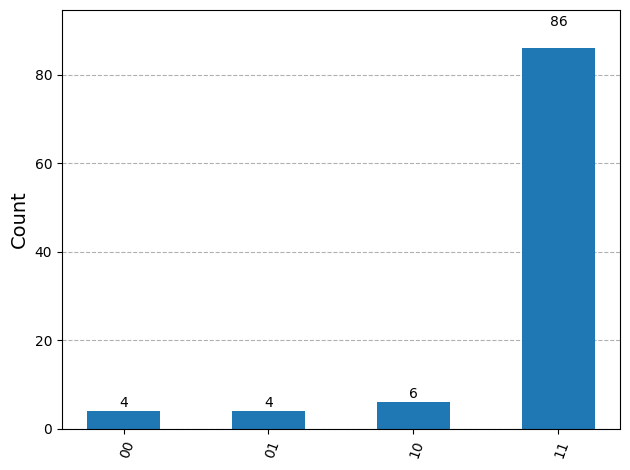

In [66]:
binary_probs = result_sim[0].data.c.get_counts()
plot_histogram(binary_probs)

### 2. Zaimplementuj algorytm teleportacji kwantowej w jednym z wybranych symulatorów

In [68]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Tworzenie obwodu z 3 kubitami kwantowymi i 2 bitami klasycznymi
qc = QuantumCircuit(QuantumRegister(3), ClassicalRegister(2))

# Dodanie bramki Hadamarda na kubicie 1, co wprowadza go w superpozycję
qc.h(1)

# Bramka CNOT - kubit 1 kontroluje kubit 2
qc.cx(1, 2)


####### POMIAR W BAZIE BELLA ##############
# Bramka CNOT - kubit 0 kontroluje kubit 1
qc.cx(0, 1)

# Kolejna bramka Hadamarda - tym razem na kubicie 0
qc.h(0)

# Pomiar kubitu 0 i zapis wyniku do klasycznego bitu 0
qc.measure(0, 0)

# Pomiar kubitu 1 i zapis wyniku do klasycznego bitu 1
qc.measure(1, 1)

#### KONIEC POMIARU W BAZIE BELLA #######

#(Alicja niszczy swój kubit i dzwoni do Bolka)

# Kolejna bramka CNOT - kubit 1 kontroluje kubit 2
qc.cx(1, 2)

# Bramka CZ - operacja kontrolowana Z na kubicie 2, kontrolowana przez kubit 0
qc.cz(0, 2)

# Wyświetlenie obwodu w formie graficznej
qc.draw()

┌───┐┌─┐        
q2_0: ────────────■──┤ H ├┤M├──────■─
      ┌───┐     ┌─┴─┐└┬─┬┘└╥┘      │ 
q2_1: ┤ H ├──■──┤ X ├─┤M├──╫───■───┼─
      └───┘┌─┴─┐└───┘ └╥┘  ║ ┌─┴─┐ │ 
q2_2: ─────┤ X ├───────╫───╫─┤ X ├─■─
           └───┘       ║   ║ └───┘   
c2: 2/═════════════════╩═══╩═════════
                       1   0

In [80]:
backend = service.least_busy(simulator=False, operational=True)
backend.name
qc_transpiled = transpile(qc, backend, optimization_level=3, seed_transpiler=0)

with Batch(backend=backend):
    sampler = SamplerV2()
    job = sampler.run(
        [qc_transpiled],
        shots=100,
    )
    result_sim = job.result()

PrimitiveResult([SamplerPubResult(data=DataBin(c2=BitArray(<shape=(), num_shots=100, num_bits=2>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-04-13 14:42:54', stop='2025-04-13 14:42:55', size=100>)])}, 'version': 2})


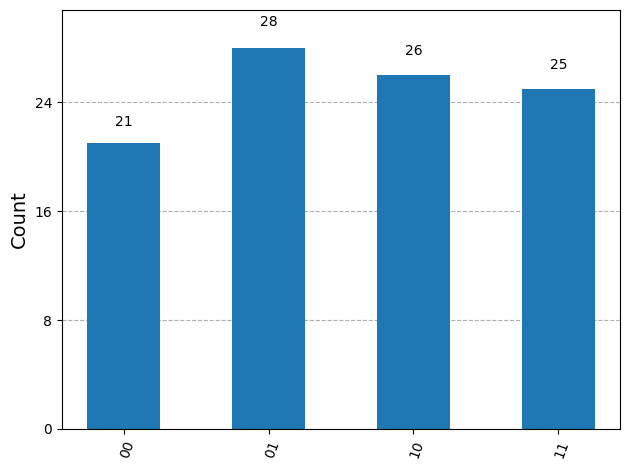

In [81]:
# wizualizacja wyników
print(result_sim)
binary_probs = result_sim[0].data.c2.get_counts()
plot_histogram(binary_probs)